# ROI Optimization

## Design of this workbook

### Testing Data
We made a synthetic imbalanced data set by dropping the majority of the positive samples of the Bone-and-Joint deep dive data

### Method tested
0. Baseline model
    - Dummy classifier
    - Vanilla lightGBM
1. Pre-processing
    - SMOT(0.1) + random undersampling(0.5)
    - Pos_class_weights
2. Optimized objective function
    - Cost optimized
    - focal loss for f1 optimization
3. Post-processing
    - Change decisioon threshold on Vanilla lightGBM output to maximize F1/AUC
    - Change decisioon threshold on focal loss algorithm output to minimize cost

### Evaluation Metrics
- F1 (main metric)
- Cost of misclassification
- matthews corrlation coefficient https://www.researchgate.net/publication/338351315_The_advantages_of_the_Matthews_correlation_coefficient_MCC_over_F1_score_and_accuracy_in_binary_classification_evaluation
- AUC

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
from numpy import where
from numpy import mean

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold,ShuffleSplit

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
#from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline

from collections import Counter
#from sklearn.datasets import make_classification
from matplotlib import pyplot

import hyperopt
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
import lightgbm as lgbm
from sklearn.dummy import DummyClassifier
#from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict,ShuffleSplit
#from imblearn.pipeline import Pipeline

from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt


NPSEED = 1337
np.random.seed(NPSEED)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Loading Data and Check Data Set

,sex_1,sex_2,admitAge,admitCategoryCode_1,admitCategoryCode_2,entryCode_1,entryCode_2,entryCode_3,entryCode_4,admitByAmbulanceCode_1,...,raDrugAlcoholAbuse,raObesity,raStroke,raMentalHealth,raHepatic,raAsthma,raRheumatoid,raHIV,raPneumonia,riskTotal
1,1,0,90.0,1,0,1,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0
2,1,0,81.0,1,0,1,0,0,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
3,1,0,72.0,1,0,1,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0
7,1,0,88.0,1,0,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
9,1,0,89.0,1,0,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


Data shape (11126, 103)


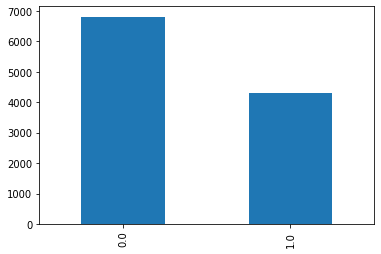

In [2]:
data = pickle.load(open('data/encoded_data.p','rb'))
display(data.head())
print(f"Data shape {data.shape}")
data['episodeDispositionCode'].value_counts().plot(kind='bar')
plt.show()
class_names =  ['Not continuing', 'Continuing Care']
features = list(data.keys())
features.remove('episodeDispositionCode')

In [3]:
data['episodeDispositionCode'].value_counts()

0.0    6807
1.0    4319
Name: episodeDispositionCode, dtype: int64

In [4]:
print('Features used:')
for feature in features:
    print(feature, end = ', ')

Features used:
sex_1, sex_2, admitAge, admitCategoryCode_1, admitCategoryCode_2, entryCode_1, entryCode_2, entryCode_3, entryCode_4, admitByAmbulanceCode_1, admitByAmbulanceCode_2, admitByAmbulanceCode_3, admitByAmbulanceCode_4, institutionZoneId_1, institutionZoneId_2, institutionZoneId_3, institutionZoneId_4, institutionZoneId_5, institutionZone_1, institutionZone_2, institutionZone_3, institutionZone_4, institutionZone_5, institutionTypeId_1, institutionTypeIdFrom_1, institutionTypeIdFrom_2, institutionTypeIdFrom_3, institutionTypeIdFrom_4, institutionTypeIdFrom_5, institutionTypeIdFrom_6, institutionTypeIdFrom_7, institutionTypeIdFrom_8, mainPatientService, mostRespDxCode_1, mostRespDxCode_2, mostRespDxCode_3, mostRespDxCode_4, mostRespDxCode_5, mostRespDxCode_6, mostRespDxCode_7, mostRespDxCode_8, mostRespDxCode_9, mostRespDxCode_10, mostRespDxCode_11, mostRespDxCode_12, mostRespDxCode_13, mostRespDxCode_14, mostRespDxCode_15, mostRespDxCode_16, mostRespDxCode_17, mostRespDxCode_1

### Create an imbalanced data set by dropping the majority of the positive samples

In [5]:
# Drop 80 of positive samples to create imbalanced data set

data_true = data.loc[data['episodeDispositionCode'] ==1].sample(frac=1).reset_index(drop=True)
data_false = data.loc[data['episodeDispositionCode'] ==0]
data_imbalance = pd.concat([data_true[:720], data_false], axis=0).sample(frac=1).reset_index(drop=True)


X_imbalance = data_imbalance.drop('episodeDispositionCode', axis=1)
y_imbalance = data_imbalance['episodeDispositionCode']
#random state used to be 42
X_train, X_test, y_train, y_test = train_test_split(X_imbalance, y_imbalance, test_size=0.20, random_state=42, stratify = y_imbalance)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42, stratify = y_train)
feat_names = list(X_train.keys())


In [6]:
minority_proportion = sum(y_train==1)/len(y_train)
print('We made up an imbalanced data set where only ', np.round(minority_proportion,2)*100,' percent of sample is positive')
print(data_imbalance['episodeDispositionCode'].value_counts())


We made up an imbalanced data set where only  10.0  percent of sample is positive
0.0    6807
1.0     720
Name: episodeDispositionCode, dtype: int64


### Performance metric:

### For Cummunicate Business Value
- Cost of misclassification
- Benefit from correct classification
- Net benefit

### For Technical Matrix
- Confusion Matrix
- F1
- MCC
- AUC



### Conditions/Things to Test On
0. Assume positive class is the minority class
1. How imbalanced the dataset is? Minority class makes up to
    - 3%
    - 10%
    - 20%
    - 40% (balanced)
2. How does the cost of false minority class compared to cost of false majority class?
    - c_n >> c_p
    - c_n << c_p (does it even make sense?)
    - c_n ~ c_p  (is that just equivalent to maximizing F1 score?)


In [7]:
# Define technical performance metric

def get_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    class_names =  ['Not continuing', 'Continuing Care']    
    df_cm = pd.DataFrame(cm, columns=class_names, index = class_names)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16},  fmt='d')
    plt.show()
    metrics = np.array( precision_recall_fscore_support(y_test, y_pred) )
    df_cm = pd.DataFrame(metrics, index=['Precision', 'Recall', 'F','Support'], columns = class_names)
    df_cm.index.name = 'Class'
    df_cm.columns.name = 'Metrics'
    display(df_cm)

In [8]:
# Define cost function for misclassifications

def Cost(y_pred, y_true, C_p, C_n):
    residual= (y_true - y_pred).astype("float")
    #print('Residual:\t',residual)
    loss = np.where(residual <=0, (residual**2)*C_p, residual**2*C_n)
    #print('Loss:\t',loss[:20])
    return np.mean(loss)

# Define Benefit function for correctly classify objectives
# We consider the scenario of churn prediction, where correctly identify positive cases means 
# capturing otherwise lost revenue at the expense of preventitive actions

def Benefit(y_true, B_p, B_n):
    
    benefit = np.where( y_true==1,1,0)*B_p+np.where( y_true==0,1,0)*B_n
    #print('Benefit:\t',benefit[:20])
    return np.mean(benefit)


# Define return function = Benefit - Cost for preventitive action
# Use 100% as the default investment percentage
def RealizedBenefit(y_pred,y_true, B_p, C_p, InvestPercent=1):
    
    if InvestPercent < 1:
        nToInvest = np.int(InvestPercent*len(y_true))
        len_new=( np.cumsum(y_pred==1) >= min (nToInvest,np.sum(y_pred)) ).argmax()+1 # length of the new array
        #print("We take the first ",len_new, " rows of the original testing set")
        y_pred_new = y_pred[:len_new]
        y_true_new = y_true[:len_new]
    else:
        y_pred_new = y_pred
        y_true_new = y_true
    
    RealizedBenefit = np.where((y_pred_new==1)&(y_true_new==1), 1,0)*B_p - np.where((y_pred_new==1), 1,0)*C_p
    #print("Total return is", np.round(np.sum(RealizedBenefit),2))
    return np.sum(RealizedBenefit)
    #return np.sum(RealizedBenefit)/len(y_true)


In [9]:
# Define weights here
c_p=1
c_n=8
b_p=c_n-c_p
b_n=0

## Baseline Model -- The Dummy Classifier, and Default Model -- Vanilla LightGBM

In [10]:
# Dummy Classifier
dummy_clf = DummyClassifier(strategy="most_frequent",random_state=33).fit(X_train,y_train) 

y_pred_dummy = dummy_clf.predict(X_test) 
y_prob_dummy = dummy_clf.predict_proba(X_test)[:,1]
y_val_pred_dummy = dummy_clf.predict(X_valid)
y_val_prob_dummy = dummy_clf.predict_proba(X_valid)[:,1]

## The defualt is_unbalance = True/False as the objective parameter
## If we use as the objective parameter, the resulting model performed the same as setting scale_pos_weight
clf_default = lgbm.LGBMClassifier(is_unbalance=False,random_state=33,learning_rate=0.1, early_stopping_rounds = 10, n_estimators=10000)

clf_default.fit(X_train,y_train,eval_set=[(X_valid, y_valid)],verbose=False)

y_pred_default = clf_default.predict(X_test)
y_prob_default = clf_default.predict_proba(X_test)[:,1]
y_val_pred_default = clf_default.predict(X_valid)
y_val_prob_default = clf_default.predict_proba(X_valid)[:,1]



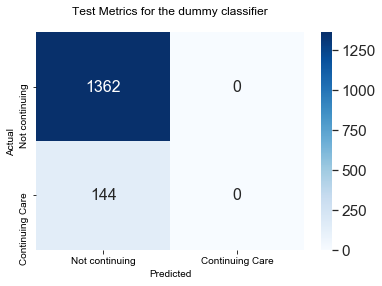

Metrics,Not continuing,Continuing Care
Class,,
Precision,0.904382,0.0
Recall,1.000000,0.0
F,0.949791,0.0
Support,1362.000000,144.0


The matthews correlation coefficient is	 0.0
The cost of miscalssification under the dummy model is 	 0.76
The benefit of the dummy model is 	 0.67


/Users/jenwei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [11]:
plt.title('Test Metrics for the dummy classifier\n')
get_metrics(y_test, y_pred_dummy)
print('The matthews correlation coefficient is\t', matthews_corrcoef(y_test, y_pred_dummy))
print('The cost of miscalssification under the dummy model is \t',np.round(Cost(y_pred_dummy, y_test, c_p, c_n),2))
print('The benefit of the dummy model is \t',np.round(Benefit(y_test,b_p, b_n),2))




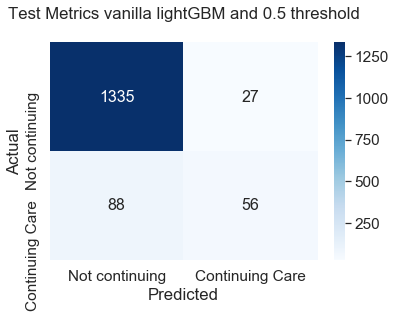

Metrics,Not continuing,Continuing Care
Class,,
Precision,0.938159,0.674699
Recall,0.980176,0.388889
F,0.958707,0.493392
Support,1362.000000,144.000000


The matthews correlation coefficient is	 0.48
The cost of miscalssification under the default model is 	 0.49
The benefit of the default model is 	 0.67


In [12]:
plt.title('Test Metrics vanilla lightGBM and 0.5 threshold\n')
get_metrics(y_test, y_pred_default)
print('The matthews correlation coefficient is\t', np.round(matthews_corrcoef(y_test, y_pred_default),2))
print('The cost of miscalssification under the default model is \t',np.round(Cost(y_pred_default, y_test, c_p, c_n),2))
print('The benefit of the default model is \t',np.round(Benefit( y_test, b_p, b_n),2))




## Customized Objective Function to Minimize 
### 1. Cost Function 
### 2.Focal Loss Function

In [13]:
# Define custom objective function -- Weighted Logistic Regression
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from scipy.misc import derivative

def weighted_loss_lgb_sk(y_true, y_pred, c_p, c_n):
    """
    Focal Loss for lightgbm

    Parameters:
    -----------
    y_pred: numpy.ndarray array with the predictions
    dtrain: lightgbm.Dataset
    c_p, c_n: float
    """
    sum = c_p+c_n
    c_p = c_p/sum
    c_n = c_n/sum
    
    def fl(x,t):
        #p = 1/(1+np.exp(-x))
        p = 1/(1+np.exp(-(x-.5)*2))
        return - ( c_n*t*np.log(p)+c_p*(1-t)*np.log(1-p) )

    
    partial_fl = lambda x: fl(x, y_true)
    grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
    hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
    return grad, hess



def weighted_loss_lgb_eval_error_sk(y_true, y_pred, c_p, c_n):
    """
    Adapation of the Focal Loss for lightgbm to be used as evaluation loss

    Parameters:
    -----------
    y_pred: numpy.ndarray
        array with the predictions
    dtrain: lightgbm.Dataset
     c_p, c_n: float
    """
 
    sum = c_p+c_n
    c_p = c_p/sum
    c_n = c_n/sum
    #p = 1/(1+np.exp(-y_pred))
    p = 1/(1+np.exp(-(y_pred-0.5)*2))
    loss = - ( c_n* y_true*np.log(p)+c_p*(1-y_true)*np.log(1-p) )
    return 'weighted_loss', np.mean(loss), False


In [14]:
# Focal loss function

def focal_loss_lgb_sk(y_true, y_pred, alpha, gamma):
    """
    Focal Loss for lightgbm

    Parameters:
    -----------
    y_pred: numpy.ndarray
        array with the predictions
    dtrain: lightgbm.Dataset
    alpha, gamma: float
        See original paper https://arxiv.org/pdf/1708.02002.pdf
    """
    a,g = alpha, gamma
    def fl(x,t):
        p = 1/(1+np.exp(-x))        
        return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) ) 
    partial_fl = lambda x: fl(x, y_true)

    grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
    hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
    return grad, hess



def focal_loss_lgb_eval_error_sk(y_true, y_pred, alpha, gamma):
    """
    Adapation of the Focal Loss for lightgbm to be used as evaluation loss

    Parameters:
    -----------
    y_pred: numpy.ndarray
        array with the predictions
    dtrain: lightgbm.Dataset
    alpha, gamma: float
        See original paper https://arxiv.org/pdf/1708.02002.pdf
    """
    a,g = alpha, gamma
    p = 1/(1+np.exp(-y_pred))
    loss = -( a*y_true + (1-a)*(1-y_true) ) * (( 1 - ( y_true*p + (1-y_true)*(1-p)) )**g) * ( y_true*np.log(p)+(1-y_true)*np.log(1-p) )
    return 'focal_loss', np.mean(loss), False

In [15]:
# Repredict y_pred_direct

# make new model on new value

#c_n=len(y_train)/sum(y_train==1)


weighted_loss = lambda x,y: weighted_loss_lgb_sk(x, y, c_p, c_n)
eval_error_weighted = lambda x,y: weighted_loss_lgb_eval_error_sk(x, y, c_p, c_n)
clf_direct = lgbm.LGBMClassifier(random_state=33,
                                early_stopping_rounds = 10,
                                learning_rate=0.1,
                                n_estimators=10000,
                                objective= weighted_loss)


#altalab.wrap.lightgbm.LGBMClassification

clf_direct.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric=eval_error_weighted,
    verbose=False,
)



y_pred_direct = clf_direct.predict(X_test)
y_prob_direct = clf_direct.predict_proba(X_test)[:,1]
y_val_pred_direct = clf_direct.predict(X_valid)
y_val_prob_direct = clf_direct.predict_proba(X_valid)[:,1]



In [20]:
# Repredict y_pred_fl

# make new model on new value
# Define alpha and gamma here

## The following parameters will produce higher F1 score for balanced data
#alpha=.25
#gamma=2

## The following parameters will produce higher F1 score for imbalanced data
alpha=.9
gamma=2


## The following parameters will produce higher recall 
## on the positive cases for imbalanced data
#alpha=.99
#gamma=1


focal_loss = lambda x,y: focal_loss_lgb_sk(x, y, alpha, gamma)
eval_error = lambda x,y: focal_loss_lgb_eval_error_sk(x, y, alpha,gamma)

clf_fl = lgbm.LGBMClassifier(random_state=33,
                                early_stopping_rounds = 10,
                                learning_rate=0.1,
                                n_estimators=10000,
                                objective= focal_loss)


clf_fl.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric=eval_error,
    verbose=False,
)


y_pred_fl = clf_fl.predict(X_test)
y_prob_fl = clf_fl.predict_proba(X_test)[:,1]
y_val_pred_fl = clf_fl.predict(X_valid)
y_val_prob_fl = clf_fl.predict_proba(X_valid)[:,1]



print('F1 score for the vaidation set of focal loss algorithm is\t',np.round(f1_score(y_valid, y_val_pred_fl),2))

F1 score for the vaidation set of focal loss algorithm is	 0.55


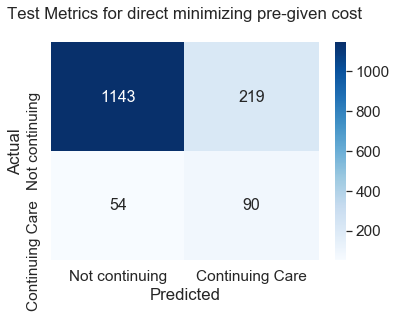

Metrics,Not continuing,Continuing Care
Class,,
Precision,0.954887,0.291262
Recall,0.839207,0.625000
F,0.893318,0.397351
Support,1362.000000,144.000000


The MCC is	 0.34
The cost of miscalssification under the direct optimized model is 	 0.43


In [18]:
plt.title('Test Metrics for direct minimizing pre-given cost\n')
get_metrics(y_test, y_pred_direct)
print('The MCC is\t', np.round(matthews_corrcoef(y_test, y_pred_direct),2)) 
print('The cost of miscalssification under the direct optimized model is \t',np.round(Cost(y_pred_direct, y_test, c_p, c_n),2))



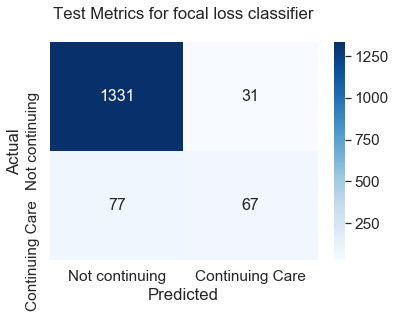

Metrics,Not continuing,Continuing Care
Class,,
Precision,0.945312,0.683673
Recall,0.977239,0.465278
F,0.961011,0.553719
Support,1362.000000,144.000000


F1= 0.554 

The MCC is	 0.53
The cost of miscalssification under the focal loss model is 	 0.43


In [21]:
plt.title('Test Metrics for focal loss classifier\n')
get_metrics(y_test, y_pred_fl)
print('F1=',np.round(f1_score(y_test, y_pred_fl),3),'\n')
print('The MCC is\t', np.round(matthews_corrcoef(y_test, y_pred_fl),2))
print('The cost of miscalssification under the focal loss model is \t',np.round(Cost(y_pred_fl, y_test, c_p, c_n),2))

## Post Processing -- Changing decision threshold

Note that there is no learning in this stage, this algorithm simply find the right level of conpromise for what you need to optimize.

Here, we consider two goals:
1. Reduce the cost associated with misclassification: minimize expected cost for misclassification
2. Achieve impartitial recogonition results on both classes: maximize F1 score
    
To this end, let us define two searching functions: 
1. GetMaxF1Threshold, 
2. GetMaxReturnThreshold, and
3. GetMinCostThreshold

It is trivial to include other metrics to optimize, as a proof of concept exercise, we only optimize F1 score or the cost for miscalssifications.    

In [22]:
## Varying threshold to find the highest F1 score
def GetMaxF1Threshold(y_true,y_pred,y_pred_prob):

    y_pred_cs = np.ones(y_true.shape)
    cmin = 999999
    vmax = -999999
    pmax = 0

    for theta in np.linspace(0,1,10):

        y_pred_cs = np.ones(y_pred.shape)
        y_pred_cs[y_pred_prob <= theta] = 0
        y_pred_cs[y_pred_prob > theta] = 1
   
        # Confusion metrix for each thredhold
        cm = confusion_matrix(y_true, y_pred_cs)
 

        class_names =  [ 'Continuing Care'] 
        metrics = np.array( precision_recall_fscore_support(y_true, y_pred_cs,beta=1,average ='binary') )
        #print('theta\t',theta,'matric\t',metrics,'\n')
    
        df_cm = pd.DataFrame(metrics, index=['Precision', 'Recall', 'F','Support'], columns = class_names)
        
        df_cm.index.name = 'Class'
        df_cm.columns.name = 'Metrics'
        #cost_to_be_mimimized = Cost(y_pred_cs, y_true, c_p, c_n)
        var_to_be_maximized =  metrics[2]
    

        if  vmax < var_to_be_maximized:
            vmax = (var_to_be_maximized)
            pmax = theta

    print(f'\n On the validation set, the best cutoffs F1 = {np.around(vmax,3)} for negative class <{np.around(pmax,2)},  and positive class >{np.around(pmax,2)}')

    return pmax,vmax


In [23]:
## Varying threshold to find the max trturn for a given investment level
def GetMaxReturnThreshold(y_true,y_pred,y_pred_prob,B_p, C_p,InvestPercent=1):

    y_pred_cs = np.ones(y_true.shape)
    cmin = 999999
    vmax = -999999
    pmax = 0

    for theta in np.linspace(-1,1,20):

        y_pred_cs = np.ones(y_pred.shape)
        y_pred_cs[y_pred_prob <= theta] = 0
        y_pred_cs[y_pred_prob > theta] = 1
   

        var_to_be_maximized =  RealizedBenefit(y_pred_cs,y_true, B_p, C_p, InvestPercent=1)
    

        if  vmax < var_to_be_maximized:
            vmax = (var_to_be_maximized)
            pmax = theta

    print(f'\n On the validation set, the best cutoffs return = {np.around(vmax,3)} for negative class <{np.around(pmax,2)},  and positive class >{np.around(pmax,2)}')

    return pmax,vmax


In [24]:
## Varying threshold to find the lowest misclassification cost
def GetMinCostThreshold(y_true,y_pred,y_pred_prob,c_p,c_n):

    y_pred_cs = np.ones(y_pred.shape)
    cmin = 999999
    vmax = -999999
    popt = 0

    for theta in np.linspace(0,1,10):

        y_pred_cs = np.ones(y_pred.shape)
        y_pred_cs[y_pred_prob <= theta] = 0
        y_pred_cs[y_pred_prob > theta] = 1
   
        cost_to_be_mimimized = Cost(y_pred_cs, y_true, c_p, c_n)
    
        if  cmin > cost_to_be_mimimized:
            cmin = cost_to_be_mimimized
            popt = theta

    print(f'\n On the validation set, the best cutoffs cost = {np.around(cmin,3)} for negative class <{np.around(popt,2)},  and positive class >{np.around(popt,2)}')

    return popt,cmin


#### Let us see how much the F1 score on Vanilla LightBGM can improve if we learn how to conpromise

In [26]:
p_max_default, f1_max_default=GetMaxF1Threshold(y_valid,y_val_pred_default,y_val_prob_default)


#print('Recall MCC is\t', np.round(matthews_corrcoef(y_test, y_pred_default),2)," for the vanilla lightGBM")
#print("MCC can be improved to", np.round(matthews_corrcoef(y_test, y_prob_default>p_max_default),2),' when we add the change thredshold post processing treatment\n')

#print("Recall F1=",np.round(f1_score(y_test, y_pred_default),3)," for the vanilla lightGBM")
#print("F1 can be improved to", np.round(f1_score(y_test, y_prob_default>p_max_default),3),' when we add the change thredshold post processing treatment\n')


p_min_default, cost_min_default=GetMinCostThreshold(y_valid,y_val_pred_default,y_val_prob_default,c_p,c_n)

#print('Recall the cost of miscalssification for vanilla LightGBM with 0.5 threshold is\t',np.round(Cost(y_prob_default, y_test, c_p, c_n),2))
#print('The mis classification cost can be reduced to \t',np.round(Cost(y_prob_default>p_min_default, y_test, c_p, c_n),2),'if we apply the optimal decision threshold\n')

#plt.title(f'Test Metrics for vanilla LightBGM\n with {np.around(p_min_default,2)} threshold when minimizing cost')
#get_metrics(y_test, y_prob_default>p_min_default)


 On the validation set, the best cutoffs F1 = 0.53 for negative class <0.33,  and positive class >0.33

 On the validation set, the best cutoffs cost = 0.388 for negative class <0.11,  and positive class >0.11


## Combing post processing with pre-processing and customizing objective functions

Although the performance of the classifier can be improved if we further turn the decision threadhold, the purpose of this section is not to beat the performance metric up to death. Rather, we use post processing as an emporical test on how fully we have pushed the model performence by the other alogorithms.

#### Recall the F1 score for scaling the weight of positive samples provided by lightBGM was rather disappointing for our dataset. Let us see if post processing can do the resecure.

In [27]:
p_max_fl, f1_max_fl=GetMaxF1Threshold(y_valid,y_val_pred_fl,y_val_prob_fl)
#plt.title(f'Test Metrics for focal loss algorithm \n with {np.around(p_max_fl,2)} threshold when maximizing F1')
#get_metrics(y_test, y_prob_fl>p_max_fl)

#print("Recall F1=",np.round(f1_score(y_test, y_pred_fl),3)," for the focal loss algorithm")
#print("\nF1 can be improved to", np.round(f1_score(y_test, y_prob_fl>p_max_fl),3),' when we add the change thredshold post processing treatment\n')

#print('The cost of miscalssification under the changing threshold method is \t',np.round(Cost(y_prob_prepross>p_max, y_test, c_p, c_n),2))




 On the validation set, the best cutoffs F1 = 0.549 for negative class <0.33,  and positive class >0.33


### Now let us see if post processing can further reduce the cost of the cost-optimized method

In [28]:
p_min_direct, cost_min_direct=GetMinCostThreshold(y_valid,y_val_pred_direct,y_val_prob_direct,c_p,c_n)
#plt.title(f'Test Metrics for cost-optimized method \n with {np.around(p_min_direct,2)} threshold when minimizing cost')
#get_metrics(y_test, y_prob_direct>p_min_direct)

#print("Recall Cost=",np.round(Cost(y_pred_direct,y_test,c_p,c_n),3)," for the cost-optimized algorithm")
#print("\nCost can be reduced to", np.round(Cost(y_prob_direct>p_min_direct,y_test,c_p,c_n),3),'\
#when we add the change thredshold post processing treatment\n')

#print('The cost of miscalssification under the changing threshold method is \t',np.round(Cost(y_prob_prepross>p_max, y_test, c_p, c_n),2))



 On the validation set, the best cutoffs cost = 0.388 for negative class <0.11,  and positive class >0.11


### Conclusion: cost and F1 cannot be further improve via post-processing if the algorithm is already cost or F1 optimized.

### But can we further reduce the cost of focal loss algorithm if we varying the decision threashold?

In [30]:
p_min_fl, cost_min_fl=GetMinCostThreshold(y_valid,y_val_pred_fl,y_val_prob_fl,c_p,c_n)
#plt.title(f'Test Metrics for focal loss algorithnm\n with {np.around(p_min_fl,2)} threshold when minimizing cost')
#get_metrics(y_test, y_prob_fl>p_min_fl)

#print("Recall Cost=",np.round(Cost(y_pred_fl,y_test,c_p,c_n),3)," for the focal loss algorithm")
#print("\nCost can be reduced to", np.round(Cost(y_prob_fl>p_min_fl,y_test,c_p,c_n),3),' when we add the change thredshold post processing treatment\n')

#print('The cost of miscalssification under the changing threshold method is \t',np.round(Cost(y_prob_prepross>p_max, y_test, c_p, c_n),2))



 On the validation set, the best cutoffs cost = 0.383 for negative class <0.0,  and positive class >0.0


## Performance Comparison Summary

In [31]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Treatment/Algorithm", "MCC (\u2191)", "F1 (\u2191)", "Cost (\u2193)"]

x.add_row(["Dummy", np.round(matthews_corrcoef(y_test, y_pred_dummy),2), \
           np.round(f1_score(y_test, y_pred_dummy),2), np.round(Cost(y_pred_dummy, y_test, c_p, c_n),2)])
x.add_row(["Vanilla lightGBM", np.round(matthews_corrcoef(y_test, y_pred_default),2), \
           np.round(f1_score(y_test, y_pred_default),2), np.round(Cost(y_pred_default, y_test, c_p, c_n),2)])

x.add_row(["Cost-optimized", np.round(matthews_corrcoef(y_test, y_pred_direct),2), \
           np.round(f1_score(y_test, y_pred_direct),2), np.round(Cost(y_pred_direct, y_test, c_p, c_n),2)])
x.add_row(["Focal Loss", np.round(matthews_corrcoef(y_test, y_pred_fl),2),\
           np.round(f1_score(y_test, y_pred_fl),2), np.round(Cost(y_pred_fl, y_test, c_p, c_n),2)])
x.add_row(["Post-pross + Vanilla", np.round(matthews_corrcoef(y_test, y_prob_default>p_max_default),2),\
           np.round(f1_score(y_test, y_prob_default>p_max_default),2), np.round(Cost(y_prob_default>p_min_default, y_test, c_p, c_n),2)])
x.add_row(["PostPross + Focal Loss", np.round(matthews_corrcoef(y_test, y_prob_fl>p_max_fl),2),\
           np.round(f1_score(y_test, y_prob_fl>p_max_fl),2), np.round(Cost(y_prob_fl>p_min_fl, y_test, c_p, c_n),2)])
print(x)

+------------------------+---------+--------+----------+
|  Treatment/Algorithm   | MCC (↑) | F1 (↑) | Cost (↓) |
+------------------------+---------+--------+----------+
|         Dummy          |   0.0   |  0.0   |   0.76   |
|    Vanilla lightGBM    |   0.48  |  0.49  |   0.49   |
|     Cost-optimized     |   0.34  |  0.4   |   0.43   |
|       Focal Loss       |   0.53  |  0.55  |   0.43   |
|  Post-pross + Vanilla  |   0.53  |  0.56  |   0.41   |
| PostPross + Focal Loss |   0.52  |  0.55  |   0.4    |
+------------------------+---------+--------+----------+


In [34]:
x = PrettyTable()

x.field_names = ["Treatment/Algorithm", "ROC_AUC (\u2191)", "Cost (\u2193)", \
                 "Return (\u2191)"]

x.add_row(["Dummy",  np.round(roc_auc_score(y_test, y_prob_dummy),2),\
           np.round(Cost(y_pred_dummy, y_test, c_p, c_n),2),\
           np.round(RealizedBenefit(y_pred_dummy, y_test, c_n, c_p),2) ])

x.add_row(["Vanilla lightGBM",  np.round(roc_auc_score(y_test, y_prob_default),2), \
           np.round(Cost(y_pred_default, y_test, c_p, c_n),2),\
          np.round(RealizedBenefit(y_pred_default, y_test, c_n, c_p),2) ])


x.add_row(["Cost-optimized", np.round(roc_auc_score(y_test, y_prob_direct),2), \
           np.round(Cost(y_pred_direct, y_test, c_p, c_n),2),\
          np.round(RealizedBenefit(y_pred_direct, y_test, c_n, c_p),2) ])

x.add_row(["Focal Loss", np.round(roc_auc_score(y_test, y_prob_fl),2), \
           np.round(Cost(y_pred_fl, y_test, c_p, c_n),2),\
          np.round(RealizedBenefit(y_pred_fl, y_test, c_n, c_p),2) ])

x.add_row(["Post-pross + Vanilla", np.round(roc_auc_score(y_test, y_prob_default),2), \
           np.round(Cost(y_prob_default>p_min_default, y_test, c_p, c_n),2), \
          np.round(RealizedBenefit(y_prob_default>p_min_default, y_test, c_n, c_p),2) ])

x.add_row(["Focal Loss + PostPross", np.round(roc_auc_score(y_test, y_prob_fl),2), \
           np.round(Cost(y_prob_fl>p_min_fl, y_test, c_p, c_n),2), \
          np.round(RealizedBenefit(y_prob_fl>p_min_fl, y_test, c_n, c_p),2) ])

print(x)


print("\n The maximum amount of net benefit that can be realized is\t" ,\
       np.round(RealizedBenefit(y_test, y_test, c_n, c_p),2) )


+------------------------+-------------+----------+------------+
|  Treatment/Algorithm   | ROC_AUC (↑) | Cost (↓) | Return (↑) |
+------------------------+-------------+----------+------------+
|         Dummy          |     0.5     |   0.76   |     0      |
|    Vanilla lightGBM    |     0.85    |   0.49   |    365     |
|     Cost-optimized     |     0.85    |   0.43   |    411     |
|       Focal Loss       |     0.85    |   0.43   |    438     |
|  Post-pross + Vanilla  |     0.85    |   0.41   |    430     |
| Focal Loss + PostPross |     0.85    |   0.4    |    443     |
+------------------------+-------------+----------+------------+

 The maximum amount of net benefit that can be realized is	 1008


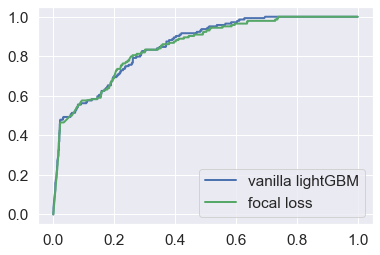

In [33]:

label='vanilla'
color='b'

fpr, tpr, thresholds = roc_curve(y_test, y_prob_default, pos_label=1)
roc_auc = auc(fpr, tpr)

roc_label = '{} (AUC={:.3f})'.format(label, roc_auc)
line_up, =plt.plot(fpr, tpr, color=color, linewidth=2, label='vanilla')



label='fl'
color='g'

fpr, tpr, thresholds = roc_curve(y_test, y_prob_fl, pos_label=1)
roc_auc = auc(fpr, tpr)

roc_label = '{} (AUC={:.3f})'.format(label, roc_auc)
line_down, = plt.plot(fpr, tpr, color=color, linewidth=2, label='fl')

plt.legend([line_up, line_down], ['vanilla lightGBM', 'focal loss'])
plt.show()

So the above is a recap of what we did in the last section

### Next, We discuss how the return changes as we put constraints on investment


In [47]:
InvestLev=np.linspace(0.005, 0.995, num=10)
ReturnLev_direct = []
ReturnLev_fl = []
ReturnLev_default = []

for x in InvestLev:
    ReturnLev_direct.append(RealizedBenefit(y_pred_direct, y_test, c_n, c_p,x))
    ReturnLev_fl.append(RealizedBenefit(y_pred_fl, y_test, c_n, c_p,x))
    ReturnLev_default.append(RealizedBenefit(y_pred_default, y_test, c_n, c_p,x))



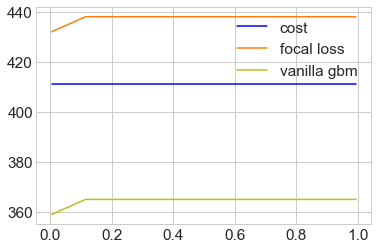

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np    

plt.plot(InvestLev, ReturnLev_direct, color='Blue',label='cost')        # specify color by name
plt.plot(InvestLev, ReturnLev_fl, color='#ff7f0e',label="focal loss")           # short color code (rgbcmyk)
plt.plot(InvestLev, ReturnLev_default, color='#bcbd22',label='vanilla gbm')  


plt.legend();
plt.show()

We have optimized our misclassification cost on a globel level. The graph above showes how return changes according to the investment level. 

### We now optimize the return on each investment level


 On the validation set, the best cutoffs return = 371 for negative class <0.58,  and positive class >0.58

 On the validation set, the best cutoffs return = 380 for negative class <-0.16,  and positive class >-0.16

 On the validation set, the best cutoffs return = 371 for negative class <0.58,  and positive class >0.58

 On the validation set, the best cutoffs return = 380 for negative class <-0.16,  and positive class >-0.16

 On the validation set, the best cutoffs return = 371 for negative class <0.58,  and positive class >0.58

 On the validation set, the best cutoffs return = 380 for negative class <-0.16,  and positive class >-0.16

 On the validation set, the best cutoffs return = 371 for negative class <0.58,  and positive class >0.58

 On the validation set, the best cutoffs return = 380 for negative class <-0.16,  and positive class >-0.16

 On the validation set, the best cutoffs return = 371 for negative class <0.58,  and positive class >0.58

 On the validation set, the 

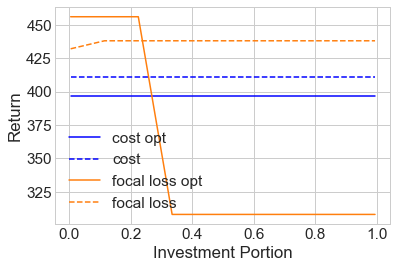

In [49]:
ReturnLev_direct_opt = []
ReturnLev_fl_opt = []

for x in InvestLev:
    #print('\nx= ',x)
    # Post processingto optimize return for the cost-optimized model at each investment level
    p_maxreturn_direct, return_maxreturn_direct\
    =GetMaxReturnThreshold(y_valid,y_val_pred_direct,y_val_prob_direct,c_n,c_p,x)
    ReturnLev_direct_opt.append(RealizedBenefit(y_prob_direct>p_maxreturn_direct,y_test,c_n,c_p,x))

    # Post processingto optimize return for the focal loss model at each investment level
    p_maxreturn_fl, return_maxreturn_fl\
    =GetMaxReturnThreshold(y_valid,y_val_pred_fl,y_val_prob_fl,c_n,c_p,x)
    ReturnLev_fl_opt.append(RealizedBenefit(y_prob_fl>p_maxreturn_fl,y_test,c_n,c_p,x))

plt.plot(InvestLev, ReturnLev_direct_opt,color='Blue',label='cost opt')        
plt.plot(InvestLev, ReturnLev_direct,'--', color='Blue',label='cost')           
plt.plot(InvestLev, ReturnLev_fl_opt, color='#ff7f0e',label='focal loss opt')
plt.plot(InvestLev, ReturnLev_fl,'--', color='#ff7f0e',label='focal loss')
plt.xlabel('Investment Portion')
plt.ylabel('Return')

plt.legend();
plt.show()    

### So instead of optimizatig the decision threahodld, let's try a sorting algorithm

In [38]:
## make the index of focal loss prediction the same as the test set
y_pred_fl=pd.Series(y_pred_fl)  # Make pred a series
y_pred_fl.index=y_test.index       # Reset it's index to be the same as y_test

y_prob_fl=pd.Series(y_prob_fl)  # Make prob a series
y_prob_fl.index=y_test.index       # Reset it's index to be the same as y_test

In [39]:
## make the index of cost-optimized prediction the same as the test set
y_pred_direct=pd.Series(y_pred_direct)  # Make pred a series
y_pred_direct.index=y_test.index       # Reset it's index to be the same as y_test

y_prob_direct=pd.Series(y_prob_direct)  # Make prob a series
y_prob_direct.index=y_test.index       # Reset it's index to be the same as y_tes

In [40]:
## make the index of vanilla lightGBM prediction the same as the test set
y_pred_default=pd.Series(y_pred_default)  # Make pred a series
y_pred_default.index=y_test.index       # Reset it's index to be the same as y_test

y_prob_default=pd.Series(y_prob_default)  # Make prob a series
y_prob_default.index=y_test.index       # Reset it's index to be the same as y_tes

In [41]:
## make the index of dummy prediction the same as the test set
y_pred_dummy=pd.Series(y_pred_dummy)  # Make pred a series
y_pred_dummy.index=y_test.index       # Reset it's index to be the same as y_test

y_prob_dummy=pd.Series(y_prob_dummy)  # Make prob a series
y_prob_dummy.index=y_test.index       # Reset it's index to be the same as y_tes

In [42]:
## Make up a perfect prediction
y_pred_perfect=y_test
y_prob_perfect=y_pred_perfect


In [43]:
## Make up a random prediction

y_prob_random=pd.Series(np.random.uniform(0,1,len(y_test)))
y_prob_random.index=y_test.index 


y_pred_random=pd.Series(np.where( y_prob_random<minority_proportion,1,0))
y_pred_random.index=y_test.index


In [44]:
## Make a function that ranks the prediction
def RankTopPrediction(y_true,y_pred,y_prob,TopNum):

    NumInvest=np.int(len(y_test)*x)
    #print("So that is ", NumInvest, " samples")

    
    #  Sort y_prob from the lowest to the highest, and keep tracking the index
    y_index_sorted=y_prob.sort_values().index

    # Investigate NumInvest cases with the highest probobility
    y_prob_top=y_prob[y_index_sorted][-TopNum:]
    
    y_pred_top=y_pred[y_index_sorted][-TopNum:]
    y_pred_top[:]=1

    # Match with the test set
    y_test_top=y_test[y_index_sorted][-TopNum:]
    
    
    
    return y_pred_top,y_test_top




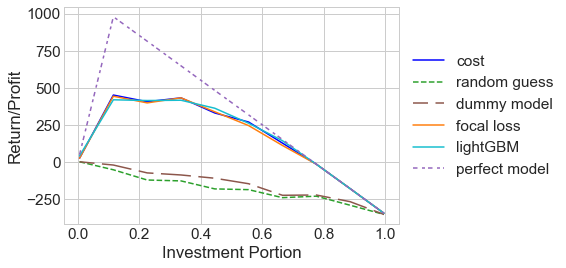

In [50]:
ReturnLev_fl_top = []
ReturnLev_direct_top = []
ReturnLev_default_top = []
ReturnLev_perfect_top=[]   # Perfect model
ReturnLev_random_top=[]   # random model
ReturnLev_dummy_top=[]   # dummy model

for x in InvestLev:
    
    #  Number of cases to investigate
    NumInvest=np.int(len(y_test)*x)
    
    y_pred_top_fl,y_test_top_fl=RankTopPrediction(y_test,y_pred_fl,y_prob_fl,NumInvest)
    y_pred_top_direct,y_test_top_direct=RankTopPrediction(y_test,y_pred_direct,y_prob_direct,NumInvest)
    y_pred_top_default,y_test_top_default=RankTopPrediction(y_test,y_pred_default,y_prob_default,NumInvest)
    y_pred_top_perfect,y_test_top_perfect=RankTopPrediction(y_test,y_pred_perfect,y_prob_perfect,NumInvest)
    y_pred_top_random,y_test_top_random=RankTopPrediction(y_test,y_pred_random,y_prob_random,NumInvest)
    y_pred_top_dummy,y_test_top_dummy=RankTopPrediction(y_test,y_pred_dummy,y_prob_dummy,NumInvest)
    
    
    
    ReturnLev_fl_top.append(RealizedBenefit(y_pred_top_fl,y_test_top_fl,c_n,c_p))
    ReturnLev_direct_top.append(RealizedBenefit(y_pred_top_direct,y_test_top_direct,c_n,c_p))
    ReturnLev_default_top.append(RealizedBenefit(y_pred_top_default,y_test_top_default,c_n,c_p))
    ReturnLev_perfect_top.append(RealizedBenefit(y_pred_top_perfect,y_test_top_perfect,c_n,c_p))
    ReturnLev_random_top.append(RealizedBenefit(y_pred_top_random,y_test_top_random,c_n,c_p))
    ReturnLev_dummy_top.append(RealizedBenefit(y_pred_top_dummy,y_test_top_dummy,c_n,c_p))
    
    
plt.plot(InvestLev, ReturnLev_direct_top,color='Blue',label='cost')        
plt.plot(InvestLev, ReturnLev_random_top,'--', color='#2ca02c',label='random guess') 
plt.plot(InvestLev, ReturnLev_dummy_top,dashes=[10, 5, 20, 5], color='#8c564b',label='dummy model')
plt.plot(InvestLev, ReturnLev_fl_top, color='#ff7f0e',label='focal loss')
plt.plot(InvestLev, ReturnLev_default_top, color='#17becf',label='lightGBM')
plt.plot(InvestLev, ReturnLev_perfect_top,dashes=[3, 3, 2, 2], color='#9467bd',label='perfect model')
plt.xlabel('Investment Portion')
plt.ylabel('Return/Profit')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

StepSize=InvestLev[1]-InvestLev[0]

In [51]:
x = PrettyTable()

x.field_names = ["Model", "AUC (\u2191)", "Highest Return (\u2191)", \
                 "Optimal Level"]



x.add_row(["Random",  np.round(sum(ReturnLev_random_top)*StepSize,2),\
           np.round(max(ReturnLev_random_top),2),\
           np.round( InvestLev[np.argmax(ReturnLev_random_top)] ,3) ,\
            ])

x.add_row(["Dummy",  np.round(sum(ReturnLev_dummy_top)*StepSize,2),\
           np.round(max(ReturnLev_dummy_top),2),\
           np.round( InvestLev[np.argmax(ReturnLev_dummy_top)] ,3) ,\
            ])

x.add_row(["Cost Optimized",  np.round(sum(ReturnLev_direct_top)*StepSize,2),\
           np.round(max(ReturnLev_direct_top),2),\
           np.round( InvestLev[np.argmax(ReturnLev_direct_top)] ,3) ,\
            ])

x.add_row(["lightGBM",  np.round(sum(ReturnLev_default_top)*StepSize,2),\
           np.round(max(ReturnLev_default_top),2),\
           np.round( InvestLev[np.argmax(ReturnLev_default_top)] ,3) ,\
            ])

x.add_row(["Focal Loss",  np.round(sum(ReturnLev_fl_top)*StepSize,2),\
           np.round(max(ReturnLev_fl_top),2),\
           np.round( InvestLev[np.argmax(ReturnLev_fl_top)] ,3) ,\
            ])

x.add_row(["Perfect",  np.round(sum(ReturnLev_perfect_top)*StepSize,2),\
           np.round(max(ReturnLev_perfect_top),2),\
           np.round( InvestLev[np.argmax(ReturnLev_perfect_top)] ,3) ,\
            ])

print(x)

+----------------+---------+--------------------+---------------+
|     Model      | AUC (↑) | Highest Return (↑) | Optimal Level |
+----------------+---------+--------------------+---------------+
|     Random     | -196.79 |         1          |     0.005     |
|     Dummy      | -165.99 |         1          |     0.005     |
| Cost Optimized |  164.89 |        451         |     0.115     |
|    lightGBM    |  166.65 |        419         |     0.115     |
|   Focal Loss   |  159.61 |        443         |     0.115     |
|    Perfect     |  318.89 |        979         |     0.115     |
+----------------+---------+--------------------+---------------+


In [785]:
InvestLev[np.argmax(ReturnLev_dummy_top)]

0.005